In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

2.12.0
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
matplotlib 3.7.2
numpy 1.23.5
pandas 1.5.3
sklearn 1.2.2
tensorflow 2.12.0
keras.api._v2.keras 2.12.0


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [4]:
# tf.keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu"))
# model.add(keras.layers.AlphaDropout(rate=0.2))#rate是丢弃的比例
# AlphaDropout相对于普通Dropout优势: 1. 均值和方差不变 2. 归一化性质也不变
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

In [5]:
tf.random.set_seed(0)
layer = tf.keras.layers.Dropout(0.5, input_shape=(2,))
# layer = tf.keras.layers.AlphaDropout(0.5, input_shape=(2,))  #改为0.2和0.1来查看效果
data = np.arange(1,13).reshape(6, 2).astype(np.float32)
print(data)

[[ 1.  2.]
 [ 3.  4.]
 [ 5.  6.]
 [ 7.  8.]
 [ 9. 10.]
 [11. 12.]]


In [6]:
outputs = layer(data, training=True)
print(outputs)

tf.Tensor(
[[ 0.  0.]
 [ 6.  8.]
 [ 0. 12.]
 [ 0. 16.]
 [18.  0.]
 [22. 24.]], shape=(6, 2), dtype=float32)


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               1

In [8]:
len(model.layers)

23

In [9]:
model.variables

[<tf.Variable 'dense/kernel:0' shape=(784, 100) dtype=float32, numpy=
 array([[-0.01432967, -0.01742917, -0.03419465, ...,  0.03629446,
          0.07037896, -0.03474404],
        [-0.02885381, -0.00323463, -0.01585463, ..., -0.01347841,
          0.06699695, -0.06354666],
        [-0.03961882,  0.03824265, -0.00609341, ...,  0.04736936,
         -0.04277361,  0.05796005],
        ...,
        [-0.02934844, -0.00854501,  0.04448147, ..., -0.03185399,
          0.0095735 , -0.06243621],
        [-0.05300239, -0.0452543 , -0.04219656, ..., -0.01697917,
          0.01049287,  0.06133555],
        [ 0.00535288, -0.01589824,  0.02218896, ...,  0.00689165,
          0.01028046,  0.01409234]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(100,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [10]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './dnn-selu-dropout-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/100
1719/1719 [==============================] - 18s 7ms/step - loss: 0.8907 - accuracy: 0.6979 - val_loss: 0.5038 - val_accuracy: 0.8208
Epoch 2/100
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5815 - accuracy: 0.8017 - val_loss: 0.4675 - val_accuracy: 0.8354
Epoch 3/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5060 - accuracy: 0.8252 - val_loss: 0.4407 - val_accuracy: 0.8458
Epoch 4/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4660 - accuracy: 0.8383 - val_loss: 0.4145 - val_accuracy: 0.8496
Epoch 5/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4348 - accuracy: 0.8471 - val_loss: 0.3862 - val_accuracy: 0.8590
Epoch 6/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4095 - accuracy: 0.8555 - val_loss: 0.3761 - val_accuracy: 0.8624
Epoch 7/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3941 - accuracy: 0.8602 - val_loss: 0.3686 -

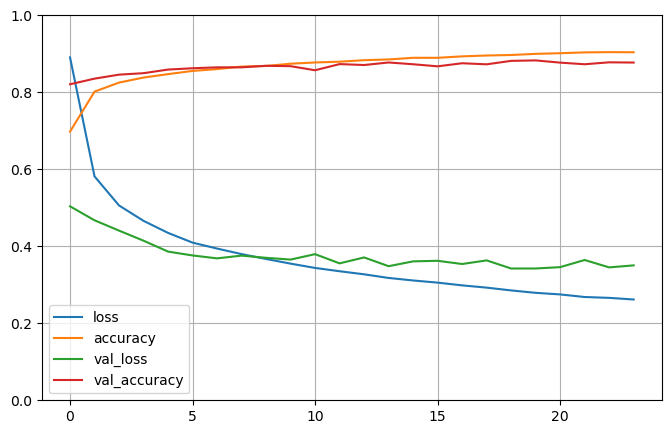

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

# 1. 参数众多，训练不充分
# 2. 梯度消失 -> 链式法则 -> 复合函数f(g(x))
#    selu缓解梯度消失

In [12]:
model.evaluate(x_test_scaled, y_test, verbose=0)

[0.39041265845298767, 0.8647000193595886]